# Regression
Uses transcript to predict severity of depresssion. Scores can range from 0 to 24. The higher the score, the more severe the depression.

# Import necessary modules

In [1]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys

# Processing
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

# Metrics
from sklearn.metrics import mean_absolute_error

# Regressors
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.kernel_ridge import KernelRidge

# Neural networks
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Embedding, Flatten
from keras.initializers import Constant
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

Using TensorFlow backend.


In [2]:
df = pd.read_csv("../../data/clean_compiled_transcripts.csv")

df.head()

,Participant_ID,Transcript,PHQ_Score,PHQ_Binary
0,300,good atlanta um my parents um i love it i like...,2,0
1,301,thank you mmm k i good thank you i los angeles...,3,0
2,302,i fine yourself i los angeles part okay um my ...,4,0
3,303,okay bout yourself yeah oh well it big broad l...,0,0
4,304,i good um los angeles um cool weather beaches ...,6,0


## Convert transcripts to padded sequences

In [3]:
RANDOM_STATE = 42 # lucky number

X = df.Transcript
y = df.PHQ_Score

In [4]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
vocab_size = len(tokenizer.word_index) + 1

tokenizer.word_index

{'i': 1,
 'um': 2,
 'it': 3,
 'uh': 4,
 'you': 5,
 'my': 6,
 'know': 7,
 'like': 8,
 'me': 9,
 'really': 10,
 'would': 11,
 'yeah': 12,
 'think': 13,
 'they': 14,
 'people': 15,
 'well': 16,
 'good': 17,
 'we': 18,
 'things': 19,
 'get': 20,
 'lot': 21,
 'time': 22,
 'go': 23,
 'she': 24,
 'he': 25,
 'pretty': 26,
 'going': 27,
 'one': 28,
 'probably': 29,
 'them': 30,
 'little': 31,
 'life': 32,
 'something': 33,
 'say': 34,
 'could': 35,
 'mm': 36,
 'feel': 37,
 'guess': 38,
 'much': 39,
 'years': 40,
 'mean': 41,
 'different': 42,
 'yes': 43,
 'kinda': 44,
 'myself': 45,
 'back': 46,
 'want': 47,
 'oh': 48,
 'see': 49,
 'right': 50,
 'got': 51,
 'sometimes': 52,
 'her': 53,
 'always': 54,
 'went': 55,
 'hard': 56,
 'ago': 57,
 'work': 58,
 'okay': 59,
 'kind': 60,
 'school': 61,
 'try': 62,
 'family': 63,
 'maybe': 64,
 'love': 65,
 'actually': 66,
 'make': 67,
 'day': 68,
 'friends': 69,
 'happy': 70,
 'way': 71,
 'thing': 72,
 'anything': 73,
 'last': 74,
 'job': 75,
 'two': 76,
 

In [5]:
maxlen = 1000

def prepare(X):
    X_seq = tokenizer.texts_to_sequences(X)
    X_mat = sequence.pad_sequences(X_seq, maxlen=maxlen)
    
    return X_mat

## Split the dataset

In [6]:
X_train_val, X_test, y_train_val, y_test = train_test_split(prepare(X), y, test_size=0.2, random_state=RANDOM_STATE)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=RANDOM_STATE)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((115, 1000), (29, 1000), (37, 1000), (115,), (29,), (37,))

Now we have `X_train`, `X_val`, `X_test`, `y_train`, `y_val`, `y_test` ready to be used for model training, validation and testing. If we are using k-fold cross-validation techniques, we can use `X_train_val`, `y_train_val`.

# More preprocesssing

In [7]:
def plot_graph(y_test, y_pred):
    plt.plot(y_test, label="y_test")
    plt.plot(y_pred, label="y_pred")
    plt.legend()

## Run model

In [8]:
def run_model(input_model, X_train, X_test, y_train, y_test):
    model = input_model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    plot_graph(y_test.to_numpy(), y_pred)
    
    print(f"Standard deviation for y_test: {y_test.std()}")
    print(f"Mean absolute error between y_test and y_pred: {mean_absolute_error(y_test, y_pred)}")
    
    return model

# Model Implementation

## Decision Tree

Standard deviation for y_test: 5.922548148945399
Mean absolute error between y_test and y_pred: 5.139358108108108


DecisionTreeRegressor(max_depth=1, min_samples_leaf=29, random_state=42)

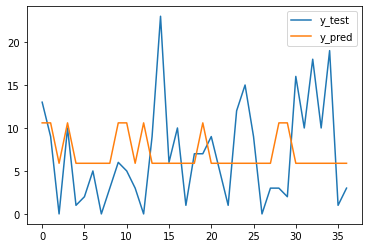

In [9]:
def find_best_tree_model(upper_depth, upper_leaf):
    best_model = None
    best_mae = sys.float_info.max
    
    for depth in range(1, upper_depth + 1):
        for leaf in range(1, upper_leaf + 1):
            model = DecisionTreeRegressor(random_state=RANDOM_STATE, max_depth=depth, min_samples_leaf=leaf) 
            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)
            
            mae = mean_absolute_error(y_val, y_pred)
            
            if mae < best_mae:
                best_mae = mae
                best_model = model
    
    return best_model

best_tree_model = find_best_tree_model(80, 30)

run_model(best_tree_model, X_train, X_test, y_train, y_test)

## Random Forest

Standard deviation for y_test: 5.922548148945399
Mean absolute error between y_test and y_pred: 4.951891891891892


RandomForestRegressor(n_estimators=50, random_state=42)

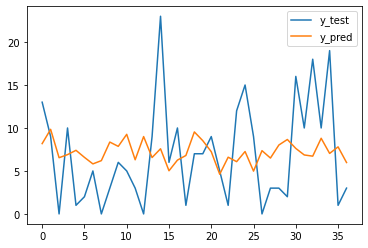

In [10]:
def find_best_forest_model(n_estimators):
    best_model = None
    best_mae = sys.float_info.max
    
    for estimator in range(1, n_estimators + 1):
        model = RandomForestRegressor(random_state=RANDOM_STATE, n_estimators=n_estimators) 
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
            
        mae = mean_absolute_error(y_val, y_pred)

        if mae < best_mae:
            best_mae = mae
            best_model = model
    
    return best_model

best_forest_model = find_best_forest_model(50)

run_model(best_forest_model, X_train, X_test, y_train, y_test)

## Kernel Ridge

Fitting 10 folds for each of 15 candidates, totalling 150 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    2.2s


Standard deviation for y_test: 5.922548148945399
Mean absolute error between y_test and y_pred: 6.459384013406277
Best ridge parameters: {'alpha': 100, 'degree': 3, 'kernel': 'poly'}


[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    2.4s finished


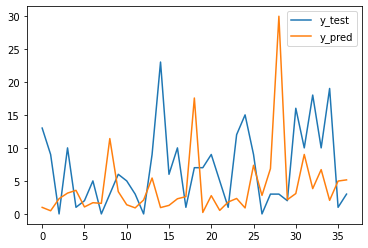

In [11]:
tuned_parameters = [{'kernel': ['rbf'], 'alpha': [1, 10, 100]},
                    {'kernel': ['poly'], 'degree': [3, 4, 5], 'alpha': [1, 10, 100]},
                    {'kernel': ['linear'], 'alpha': [1, 10, 100]}]

ridge_model_cv = GridSearchCV(KernelRidge(), tuned_parameters, cv=10, scoring='neg_mean_absolute_error', verbose=1, n_jobs=4)

best_ridge_model = run_model(ridge_model_cv, X_train_val, X_test, y_train_val, y_test)
print(f"Best ridge parameters: {best_ridge_model.best_params_}")

## Long Short Term Memory networks 

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(100, dropout=0.2, recurrent_dropout=0.2)`
  after removing the cwd from sys.path.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 128)         1004544   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               91600     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               25856     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 1,122,257
Trainable params: 1,122,257
Non-trainable params: 0
_________________________________________________________________
None


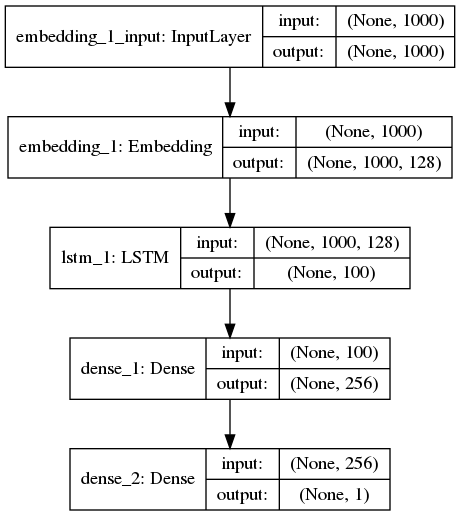

In [12]:
lstm_model = Sequential()

lstm_model.add(Embedding(vocab_size, 128, input_length=maxlen, dropout=0.2))
lstm_model.add(LSTM(100, dropout_U = 0.2, dropout_W = 0.2))
lstm_model.add(Dense(256, bias_initializer=Constant(0.01)))
lstm_model.add(Dense(1, bias_initializer=Constant(0.01)))

print(lstm_model.summary())
plot_model(lstm_model, to_file='lstm_regression.png', show_shapes=True)

In [13]:
batch_size = 32
es = EarlyStopping(monitor='val_loss', mode='min', patience=10)

lstm_model.compile(loss='mae', optimizer='adam', metrics=['mae'])
checkpoint_filepath = 'lstm_model.h5'

checkpoint =  ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', mode='min', save_best_only=True)

lstm_model.fit(X_train, y_train, batch_size=batch_size, epochs=50, validation_data=(X_val, y_val), callbacks=[es, checkpoint])
loss, mae = lstm_model.evaluate(X_test, y_test, batch_size=batch_size)

lstm_model = load_model(checkpoint_filepath)

print('Test loss:', loss)
print('Test mae:', mae)

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 115 samples, validate on 29 samples
Epoch 1/50
115/115 [==============================] - 7s 57ms/step - loss: 7.1846 - mae: 7.1846 - val_loss: 4.8596 - val_mae: 4.8596
Epoch 2/50
115/115 [==============================] - 5s 48ms/step - loss: 7.0138 - mae: 7.0138 - val_loss: 4.5540 - val_mae: 4.5540
Epoch 3/50
115/115 [==============================] - 5s 48ms/step - loss: 6.3927 - mae: 6.3927 - val_loss: 3.9444 - val_mae: 3.9444
Epoch 4/50
115/115 [==============================] - 6s 56ms/step - loss: 5.7534 - mae: 5.7534 - val_loss: 5.1976 - val_mae: 5.1976
Epoch 5/50
115/115 [==============================] - 5s 47ms/step - loss: 5.2745 - mae: 5.2745 - val_loss: 4.1614 - val_mae: 4.1614
Epoch 6/50
115/115 [==============================] - 5s 48ms/step - loss: 5.0668 - mae: 5.0668 - val_loss: 4.1552 - val_mae: 4.1552
Epoch 7/50
115/115 [==============================] - 6s 48ms/step - loss: 5.2334 - mae: 5.2334 - val_loss: 4.1337 - val_mae: 4.1337
Epoch 8/50
115/115 [====

[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
[13  9  0 10  1  2  5  0  3  6  5  3  0  9 23  6 10  1  7  7  9  5  1 12
 15  9  0  3  3  2 16 10 18 10 19  1  3] 

Standard deviation for y_test: 5.922548148945399
Mean absolute error between y_test and y_pred: 4.714767352954762


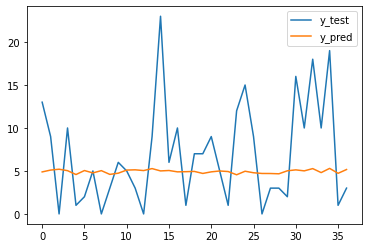

In [14]:
predictions = lstm_model.predict(X_test)
y_pred = predictions.flatten()

print(np.round(y_pred).astype(int))
print(y_test.to_numpy(), '\n')
print(f"Standard deviation for y_test: {y_test.std()}")
print(f"Mean absolute error between y_test and y_pred: {mean_absolute_error(y_test, y_pred)}")

plot_graph(y_test.to_numpy(), y_pred)